# RAG 시스템 평가 (RAG Evaluation)

이 노트북에서는 RAG 시스템의 **검색 품질**과 **답변 품질**을 정량적으로 측정하는 방법을 학습합니다.

## 학습 목표

| 섹션 | 내용 |
|------|------|
| 1. 테스트 데이터 | TestQuestion 모델, JSONL 로드 |
| 2. RAG 시스템 연결 | 벡터스토어 + LLM 파이프라인 |
| 3. 검색 평가 지표 | MRR, nDCG, Precision@K, Recall@K, Keyword Coverage |
| 4. 답변 평가 | LLM-as-a-Judge (Accuracy, Completeness, Relevance) |
| 5. 배치 평가 | 전체 테스트셋 평가 + 시각화 |

## RAG 평가가 중요한 이유

RAG 시스템은 **검색(Retrieval)**과 **생성(Generation)** 두 단계로 구성됩니다.  
각 단계를 개별적으로 평가해야 문제의 원인을 정확히 파악할 수 있습니다.

| 상황 | 검색 | 생성 | 진단 |
|------|------|------|------|
| 검색이 문서를 못 찾음 | **낮음** | - | 임베딩/청킹 개선 필요 |
| 문서는 찾았으나 답변이 부정확 | 높음 | **낮음** | 프롬프트/모델 개선 필요 |
| 모두 잘 동작 | 높음 | 높음 | 유지 + 모니터링 |

In [12]:
import os
import json
import math
import glob
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
from pydantic import BaseModel, Field
from dotenv import load_dotenv
from litellm import completion

from langchain_community.document_loaders import DirectoryLoader, TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.documents import Document

load_dotenv(override=True)

# 설정
MODEL = "gpt-4.1-nano"
KNOWLEDGE_BASE = str(Path("../00_test_data/knowledge_base"))
DB_NAME = "vector_db"
TEST_FILE = str(Path("../00_test_data/test_dataset/tests.jsonl"))
RETRIEVAL_K = 10

# matplotlib 한글 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")


def normalize_source(source_path: str) -> str:
    """청크 metadata의 source 경로를 정규화하여 knowledge_base/ 이하 상대 경로로 변환

    예시: '../00_test_data/knowledge_base/company/overview.md' → 'company/overview.md'
    """
    if "knowledge_base/" in source_path:
        return source_path.split("knowledge_base/")[-1]
    return source_path


print(f"모델: {MODEL}")
print(f"Knowledge Base: {KNOWLEDGE_BASE}")
print(f"벡터DB: {DB_NAME}")
print(f"테스트 파일: {TEST_FILE}")

모델: gpt-4.1-nano
Knowledge Base: ../00_test_data/knowledge_base
벡터DB: vector_db
테스트 파일: ../00_test_data/test_dataset/tests.jsonl


---

## 1. 테스트 데이터 구조

RAG 평가를 위한 테스트 데이터는 JSONL 형식으로 관리합니다.  
각 테스트 케이스는 **질문 + 키워드 + 정답 + 카테고리 + 정답 문서** 로 구성됩니다.

### 필드 설명

| 필드 | 설명 | 예시 |
|------|------|------|
| `question` | RAG 시스템에 던질 질문 | "하늘여행사 창립자는?" |
| `keywords` | 검색 결과에 포함되어야 하는 키워드들 | `["김하늘"]` |
| `reference_answer` | 정답 (Ground Truth) | "하늘여행사의 창립자는 김하늘입니다." |
| `category` | 질문 카테고리 | `"direct_fact"` |
| `source_docs` | 정답이 포함된 원본 문서 경로들 | `["company/overview.md"]` |

### 질문 카테고리

| 카테고리 | 설명 | 예시 |
|---------|------|------|
| `direct_fact` | 단일 문서에서 직접 찾을 수 있는 사실 | "하늘여행사 창립자는?" |
| `temporal` | 시간/날짜 관련 질문 | "언제 설립되었나?" |
| `spanning` | 여러 문서를 종합해야 하는 질문 | "A가 담당하는 제품은?" |
| `numerical` | 숫자/통계 관련 질문 | "직원 수는?" |
| `comparative` | 비교/분석 질문 | "가장 비싼 상품은?" |
| `holistic` | 전체적인 이해가 필요한 질문 | "총 계약 건수는?" |

### source_docs 필드의 역할

`source_docs`는 **검색 평가(MRR, nDCG, Precision, Recall)** 에서 정답 판정 기준으로 사용됩니다.  
검색된 청크의 `metadata["source"]`를 정규화하여 `source_docs`에 포함되는지로 관련성을 판단합니다.

```
검색된 청크의 source: "../00_test_data/knowledge_base/company/overview.md"
     → 정규화: "company/overview.md"
     → source_docs에 포함? → 관련 문서!
```

In [13]:
class TestQuestion(BaseModel):
    """RAG 평가용 테스트 질문 모델"""
    question: str = Field(description="RAG 시스템에 던질 질문")
    keywords: list[str] = Field(description="검색 결과에 포함되어야 하는 키워드들")
    reference_answer: str = Field(description="정답 (Ground Truth)")
    category: str = Field(description="질문 카테고리")
    source_docs: list[str] = Field(default_factory=list, description="정답이 포함된 원본 문서 경로들")


def load_tests(filepath: str = TEST_FILE) -> list[TestQuestion]:
    """JSONL 파일에서 테스트 케이스 로드"""
    tests = []
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            data = json.loads(line)
            tests.append(TestQuestion(**data))
    return tests

In [14]:
# 테스트 데이터 로드 및 카테고리 분포 확인
tests = load_tests()
print(f"총 {len(tests)}개의 테스트 케이스 로드됨\n")

# 카테고리별 분포
category_counts = Counter(t.category for t in tests)
print("카테고리별 분포:")
for cat, count in sorted(category_counts.items()):
    print(f"  {cat}: {count}개")

# 첫 번째 테스트 확인
t = tests[0]
print(f"\n[테스트 예시]")
print(f"  Question    : {t.question}")
print(f"  Keywords    : {t.keywords}")
print(f"  Answer      : {t.reference_answer}")
print(f"  Category    : {t.category}")
print(f"  Source Docs : {t.source_docs}")

총 146개의 테스트 케이스 로드됨

카테고리별 분포:
  comparative: 19개
  direct_fact: 49개
  holistic: 10개
  numerical: 20개
  relationship: 15개
  spanning: 14개
  temporal: 19개

[테스트 예시]
  Question    : 하늘여행사는 언제 설립되었나요?
  Keywords    : ['2008년', '3월 15일']
  Answer      : 하늘여행사는 2008년 3월 15일에 설립되었습니다.
  Category    : direct_fact
  Source Docs : ['company/overview.md', 'company/history.md', 'employees/kim_haneul.md']


---

## 2. RAG 시스템 연결

Knowledge Base의 마크다운 문서를 로드하고, 청킹 후 벡터스토어에 저장합니다.

### 파이프라인

```
00_test_data/knowledge_base/ (md 파일들)
  → DirectoryLoader (문서 로드)
  → RecursiveCharacterTextSplitter (청킹)
  → Chroma 벡터스토어 (임베딩 + 저장)
  → Retriever + LLM (검색 + 답변 생성)
```

In [ ]:
def fetch_documents() -> list[Document]:
    """Knowledge Base에서 마크다운 문서 로드"""
    folders = glob.glob(os.path.join(KNOWLEDGE_BASE, "*"))
    documents = []

    for folder in folders:
        doc_type = os.path.basename(folder)
        loader = DirectoryLoader(
            folder,
            glob="**/*.md",
            loader_cls=TextLoader,
            loader_kwargs={"encoding": "utf-8"},
        )
        folder_docs = loader.load()
        # 각 Document 객체에 자동으로 metadata가 붙음 (예: source)
        for doc in folder_docs:
            doc.metadata["doc_type"] = doc_type
            documents.append(doc)

    return documents


def create_chunks(documents: list[Document]) -> list[Document]:
    """문서를 청크로 분할"""
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=200,
    )
    return text_splitter.split_documents(documents)


def create_vectorstore(chunks: list[Document]) -> Chroma:
    """벡터스토어 생성 (기존 DB 삭제 후 재생성)"""
    if os.path.exists(DB_NAME):
        Chroma(persist_directory=DB_NAME, embedding_function=embeddings).delete_collection()

    vectorstore = Chroma.from_documents(
        documents=chunks,
        embedding=embeddings,
        persist_directory=DB_NAME,
    )
    return vectorstore


print("Ingest 함수 정의 완료: fetch_documents, create_chunks, create_vectorstore")

Ingest 함수 정의 완료: fetch_documents, create_chunks, create_vectorstore


In [20]:
# Knowledge Base → 벡터스토어 구축
documents = fetch_documents()
print(f"로드된 문서: {len(documents)}개")

for doc_type in set(doc.metadata["doc_type"] for doc in documents):
    count = sum(1 for doc in documents if doc.metadata["doc_type"] == doc_type)
    print(f"  {doc_type}: {count}개")

chunks = create_chunks(documents)
print(f"\n생성된 청크: {len(chunks)}개")

vectorstore = create_vectorstore(chunks)
print(f"벡터스토어 저장 완료: {vectorstore._collection.count()}개 청크 → {DB_NAME}/")

{'source': '../00_test_data/knowledge_base/products/vietnam_danang.md', 'doc_type': 'products'}
{'source': '../00_test_data/knowledge_base/products/japan_osaka.md', 'doc_type': 'products'}
{'source': '../00_test_data/knowledge_base/products/jeju_healing.md', 'doc_type': 'products'}
{'source': '../00_test_data/knowledge_base/products/maldives_honeymoon.md', 'doc_type': 'products'}
{'source': '../00_test_data/knowledge_base/faq/product.md', 'doc_type': 'faq'}
{'source': '../00_test_data/knowledge_base/faq/general.md', 'doc_type': 'faq'}
{'source': '../00_test_data/knowledge_base/contracts/samsung_incentive.md', 'doc_type': 'contracts'}
{'source': '../00_test_data/knowledge_base/contracts/hyundai_mice.md', 'doc_type': 'contracts'}
{'source': '../00_test_data/knowledge_base/policies/cancellation.md', 'doc_type': 'policies'}
{'source': '../00_test_data/knowledge_base/policies/booking.md', 'doc_type': 'policies'}
{'source': '../00_test_data/knowledge_base/policies/insurance.md', 'doc_type': 

In [17]:
# 벡터스토어가 이미 생성되어 있으면 로드만 수행
# vectorstore = Chroma(persist_directory=DB_NAME, embedding_function=embeddings)
# print(f"벡터스토어 로드 완료: {vectorstore._collection.count()}개 청크")

retriever = vectorstore.as_retriever(search_kwargs={"k": RETRIEVAL_K})
llm = ChatOpenAI(model=MODEL, temperature=0)

SYSTEM_PROMPT = """
You are a knowledgeable, friendly assistant representing the company.
If relevant, use the given context to answer any question.
If you don't know the answer, say so.
Context:
{context}
"""


def fetch_context(question: str) -> list[Document]:
    """질문과 관련된 문서 검색"""
    return retriever.invoke(question)


def answer_question(question: str) -> tuple[str, list[Document]]:
    """RAG 방식으로 질문에 답변"""
    context_docs = fetch_context(question)
    context_text = "\n\n".join(doc.page_content for doc in context_docs)

    messages = [
        SystemMessage(content=SYSTEM_PROMPT.format(context=context_text)),
        HumanMessage(content=question),
    ]
    response = llm.invoke(messages)
    return response.content, context_docs


print(f"Retriever 준비 완료 (K={RETRIEVAL_K})")

Retriever 준비 완료 (K=10)


In [18]:
# RAG 시스템 동작 확인
test_q = tests[0]
answer, docs = answer_question(test_q.question)

print(f"질문: {test_q.question}")
print(f"정답: {test_q.reference_answer}")
print(f"\nRAG 답변: {answer}")
print(f"\n검색된 문서 수: {len(docs)}")

질문: 하늘여행사는 언제 설립되었나요?
정답: 하늘여행사는 2008년 3월 15일에 설립되었습니다.

RAG 답변: 하늘여행사는 2008년 3월 15일에 설립되었습니다.

검색된 문서 수: 10


---

## 3. 검색 평가 지표 (Retrieval Metrics)

### 3.1 MRR (Mean Reciprocal Rank)

#### 한 줄 요약
> "정답 문서가 검색 결과에서 **몇 번째에 나왔는지**를 점수로 바꾼 것"

#### 비유로 이해하기

구글에서 무언가를 검색했을 때를 떠올려 보세요.

- 원하는 결과가 **1번째**에 나오면 → 기분 좋음 (점수: **1.0**)
- **2번째**에 나오면 → 괜찮음 (점수: **0.5**)
- **5번째**에 나오면 → 좀 아쉬움 (점수: **0.2**)
- **10번째**에 나오면 → 거의 못 찾을 뻔 (점수: **0.1**)
- 아예 못 찾으면 → 검색 실패 (점수: **0**)

점수 = `1 / 정답이 나온 순위` 입니다. 이것이 **Reciprocal Rank (RR)** 입니다.

#### 문서 ID 기반 평가

이 노트북에서는 **문서 ID(source document) 기반**으로 MRR을 계산합니다.

- 각 테스트에는 `source_docs` 필드가 있고, 정답이 포함된 원본 문서 경로를 담고 있습니다.
- 검색된 청크의 `metadata["source"]`를 정규화하여 `source_docs`와 비교합니다.
- 첫 번째로 정답 문서의 청크가 나타난 순위가 RR이 됩니다.

```
질문: "하늘여행사는 언제 설립되었나요?"
source_docs: ["company/overview.md", "company/history.md"]

검색 결과:
  1번째: employees/kim_haneul.md 청크 → source_docs에 없음 (X)
  2번째: company/overview.md 청크 → source_docs에 있음! (O)

RR = 1/2 = 0.5.  (두번째 문서에서 정답이 나왔기 때문에 1/2)
```

> **키워드 기반과의 차이**: 키워드 방식은 `page_content`에 특정 키워드가 포함되는지를 확인하지만,
> 문서 ID 방식은 해당 청크가 **정답 문서에서 왔는지**를 확인합니다.
> 문서 ID 방식이 실무 표준이며, 청크 내용과 무관하게 출처를 기반으로 판단합니다.

#### MRR = 여러 질문의 RR 평균

| 질문 | 정답 문서 첫 출현 위치 | RR |
|------|-----------|-----|
| "설립일은?" | 2번째 | 1/2 = 0.50 |
| "창립자는?" | 1번째 | 1/1 = 1.00 |
| "직원 수는?" | 5번째 | 1/5 = 0.20 |

**MRR** = (0.50 + 1.00 + 0.20) / 3 = **0.567**

#### 공식

```
MRR = (1/Q) × Σ(1/rank_i)
```
- Q: 전체 질문 수, rank_i: i번째 질문에서 첫 번째 정답 문서 청크의 순위

#### 점수 해석

| 점수 | 의미 |
|------|------|
| MRR >= 0.9 | 거의 항상 1~2번째에 정답이 나옴 (우수) |
| MRR >= 0.75 | 대체로 상위권에 정답이 나옴 (양호) |
| MRR < 0.75 | 정답이 너무 뒤에 나옴 (개선 필요) |

#### 특징과 한계
- **장점**: 직관적이고 계산이 간단함
- **한계**: 첫 번째 정답만 봄 — 관련 문서가 여러 개 있어도 **가장 먼저 나온 1개**만 반영

-  실제 검색된 chunk 에 정받이 없어도 있다고 판단할 수 있는거 아냐?  
   * 맞습니다. 그게 문서 ID 기반 평가의 한계입니다. 예를 들어:
   * company/overview.md에 "회사 설립일", "대표이사", "사업 분야" 등 여러 청크가 있을 때 질문은 "설립일"인데, 검색된 청크는 "대표이사" 관련 내용일 수 있음
   * 그래도 source가 company/overview.md이므로 정답으로 처리됨. 즉, 출처만 맞으면 내용이 엉뚱해도 hit로 판정하는 거죠.

그래서 실무에서는 보통 두 가지를 병행합니다:
   * 문서 ID 기반: 검색이 올바른 문서를 찾아오는지 (coarse-grained 평가)
   * 키워드/의미 기반: 검색된 청크가 실제로 답변에 필요한 내용을 담고 있는지 (fine-grained 평가)

In [ ]:
def calculate_mrr(source_docs: list[str], retrieved_docs: list[Document]) -> float:
    """
    문서 ID 기반 MRR(Reciprocal Rank) 계산

    Args:
        source_docs: 정답 문서 경로 리스트 (예: ["company/overview.md"])
        retrieved_docs: 검색된 문서 리스트

    Returns:
        Reciprocal Rank (정답 순위의 역수, 0~1)
    """
    source_set = set(source_docs)
    for rank, doc in enumerate(retrieved_docs, start=1):
        if normalize_source(doc.metadata.get("source", "")) in source_set:
            return 1.0 / rank
    return 0.0


# MRR 테스트
test = tests[0]
docs = fetch_context(test.question)

print(f"질문: {test.question}")
print(f"정답 문서: {test.source_docs}\n")

mrr = calculate_mrr(test.source_docs, docs)
print(f"MRR: {mrr:.4f}\n")

print("검색된 문서 순위:")
for i, doc in enumerate(docs, 1):
    src = normalize_source(doc.metadata.get("source", ""))
    hit = "O" if src in set(test.source_docs) else "X"
    print(f"  {i}. [{hit}] {src}")

### 3.2 nDCG (Normalized Discounted Cumulative Gain)

#### 한 줄 요약
> "관련 문서가 **위쪽에 몰려 있을수록** 높은 점수를 주는 지표"

#### MRR과 뭐가 다른가요?

MRR은 **첫 번째 정답만** 봅니다. 정답이 1번째에 나오면 그 뒤에 뭐가 오든 1.0점입니다.

하지만 현실에서는 이런 상황이 있습니다:

```
검색 결과 A: [정답] [쓰레기] [쓰레기] [쓰레기] [쓰레기]  → MRR = 1.0
검색 결과 B: [정답] [정답]   [정답]   [쓰레기] [쓰레기]  → MRR = 1.0
```

MRR로는 A와 B가 동일하지만, **B가 더 좋은 검색 결과**입니다.  
nDCG는 이 차이를 반영합니다 — **전체 순위의 품질**을 평가하기 때문입니다.

| | MRR | nDCG |
|---|-----|------|
| 보는 범위 | 가장 먼저 나온 **1개**만 | 상위 K개 **전부** |
| 관련성 | 정답/오답 (0 or 1) | **등급 평가** 가능 (0, 1, 2, 3...) |
| 핵심 질문 | 첫 번째 정답이 얼마나 빨리 나오는가? | 전체 검색 결과의 순서가 적절한가? |
| 평가 기준 | 문서 ID (source_docs) | 문서 ID (source_docs) |

#### 비유로 이해하기: 시험 답안지 채점

10문제 시험에서 맞은 문제(O)와 틀린 문제(X)가 있다고 합시다.

- **앞쪽 문제**를 맞히면 점수를 **크게** 줌 (1번 문제 = 배점 높음)
- **뒤쪽 문제**를 맞히면 점수를 **조금** 줌 (10번 문제 = 배점 낮음)

이것이 바로 "**Discounted(할인)**"의 의미입니다.  
뒤로 갈수록 가치가 줄어드는 것이죠.

#### 구체적인 예시로 계산하기

"하늘여행사는 언제 설립되었나요?"  
`source_docs: ["company/overview.md", "company/history.md"]`

검색 결과 10개가 반환되었다고 합시다:

```
순위  문서                        정답?  관련성
1     company/overview.md          O      1
2     company/history.md           O      1
3     employees/kim_haneul.md      X      0
4     company/overview.md (청크2)  O      1
5     faq/general.md               X      0
```

**Step 1: DCG 계산** — 관련성을 순위에 따라 "할인"합니다

```
DCG = 1/log₂(2) + 1/log₂(3) + 0/log₂(4) + 1/log₂(5) + 0/log₂(6)
    = 1/1.0     + 1/1.585   + 0          + 1/2.322   + 0
    = 1.000     + 0.631     + 0          + 0.431     + 0
    = 2.062
```

> 핵심 포인트: 1번째(1.0)와 4번째(0.431) 모두 정답이지만, **순위가 높을수록 점수 기여가 큼**

**Step 2: IDCG 계산** — "이상적인 배치"의 DCG

관련 문서가 모두 맨 앞에 온 최선의 경우:

```
이상적 순위: [1, 1, 1, 0, 0]  (관련 3개가 앞에 모임)

IDCG = 1/log₂(2) + 1/log₂(3) + 1/log₂(4) + 0 + 0
     = 1.000     + 0.631     + 0.500     + 0 + 0
     = 2.131
```

**Step 3: 정규화** — "최선 대비 얼마나 좋은가?"

```
nDCG = DCG / IDCG = 2.062 / 2.131 = 0.968
```

→ 이상적 배치의 **96.8%** 수준으로 좋은 검색 결과!

#### 만약 정답이 뒤쪽에 몰려있다면?

```
순위: [X, X, X, O, O]  → 관련성: [0, 0, 0, 1, 1]

DCG  = 0 + 0 + 0 + 1/log₂(5) + 1/log₂(6) = 0.431 + 0.387 = 0.818
IDCG = 1/log₂(2) + 1/log₂(3) = 1.000 + 0.631 = 1.631

nDCG = 0.818 / 1.631 = 0.502
```

→ 같은 수의 정답이지만 **뒤에 몰려 있어서 점수가 크게 낮아짐**

#### 공식

```
DCG@K  = Σᵢ₌₁ᴷ (relᵢ / log₂(i + 1))
IDCG@K = DCG@K with ideal ranking (관련 문서를 모두 앞으로 배치)
nDCG@K = DCG@K / IDCG@K
```

- `relᵢ`: i번째 청크의 관련성 (정답 문서 출처 → 1, 아니면 → 0)
- `log₂(i+1)`: 순위 할인 계수 (뒤로 갈수록 커짐 → 기여도 감소)

#### 점수 해석

| 점수 | 의미 |
|------|------|
| nDCG >= 0.9 | 관련 문서가 상위에 잘 배치됨 (우수) |
| nDCG >= 0.75 | 대체로 좋은 순서이나 개선 여지 있음 (양호) |
| nDCG < 0.75 | 관련 문서가 뒤쪽에 몰려 있음 (개선 필요) |

#### 특징과 한계
- **장점**: 전체 순위 품질을 종합적으로 평가, 등급화된 관련성도 처리 가능
- **한계**: MRR보다 직관적이지 않음, K 값에 따라 결과가 달라질 수 있음

In [27]:
def calculate_dcg(relevances: list[int], k: int) -> float:
    """Discounted Cumulative Gain 계산"""
    dcg = 0.0
    for i in range(min(k, len(relevances))):
        dcg += relevances[i] / math.log2(i + 2)  # rank 1부터 시작
    return dcg


def calculate_ndcg(source_docs: list[str], retrieved_docs: list[Document], k: int = 10) -> float:
    """
    문서 ID 기반 nDCG 계산 (Binary Relevance)

    Args:
        source_docs: 정답 문서 경로 리스트
        retrieved_docs: 검색된 문서 리스트
        k: 상위 k개 문서만 고려

    Returns:
        Normalized DCG (0~1)
    """
    source_set = set(source_docs)
    relevances = [
        1 if normalize_source(doc.metadata.get("source", "")) in source_set else 0
        for doc in retrieved_docs[:k]
    ]

    dcg = calculate_dcg(relevances, k)
    idcg = calculate_dcg(sorted(relevances, reverse=True), k)
    return dcg / idcg if idcg > 0 else 0.0


# nDCG 테스트
test = tests[0]
docs = fetch_context(test.question)

print(f"질문: {test.question}")
print(f"정답 문서: {test.source_docs}\n")

ndcg = calculate_ndcg(test.source_docs, docs)
print(f"nDCG: {ndcg:.4f}")

질문: 하늘여행사는 언제 설립되었나요?
정답 문서: ['company/overview.md', 'company/history.md', 'employees/kim_haneul.md']

nDCG: 1.0000


### 3.3 Precision@K / Recall@K

**Precision@K**: 검색된 K개 중 정답 비율 (품질 관점)  
**Recall@K**: 전체 정답 중 K개 안에 찾은 비율 (커버리지 관점)

```
Precision@K = (K개 중 정답 수) / K
Recall@K    = (K개 중 정답 수) / 전체 정답 수
```

**트레이드오프**: K를 늘리면 Recall은 올라가지만 Precision은 내려가는 경향이 있습니다.

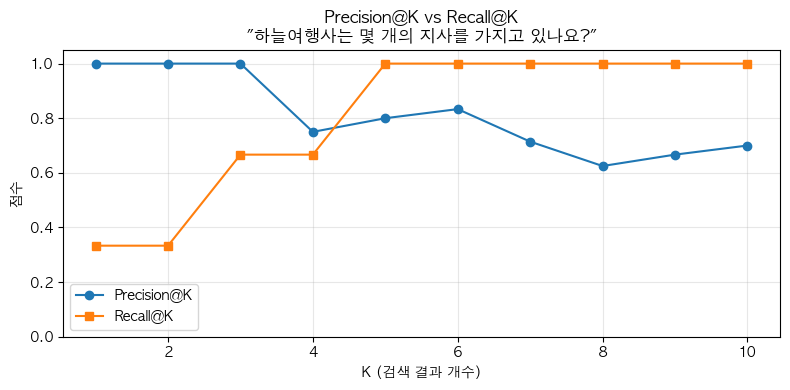

정답 문서: ['company/overview.md', 'company/history.md', 'faq/general.md']


In [28]:
def calculate_precision_at_k(source_docs: list[str], retrieved_docs: list[Document], k: int) -> float:
    """
    Precision@K: 상위 K개 청크 중 정답 문서에서 온 청크의 비율

    Args:
        source_docs: 정답 문서 경로 리스트
        retrieved_docs: 검색된 문서 리스트
        k: 상위 k개 고려
    """
    if k <= 0:
        return 0.0
    source_set = set(source_docs)
    top_k = retrieved_docs[:k]
    relevant = sum(
        1 for doc in top_k
        if normalize_source(doc.metadata.get("source", "")) in source_set
    )
    return relevant / k


def calculate_recall_at_k(source_docs: list[str], retrieved_docs: list[Document], k: int) -> float:
    """
    Recall@K: 정답 문서 중 상위 K개에서 1개라도 청크가 검색된 문서의 비율

    Args:
        source_docs: 정답 문서 경로 리스트
        retrieved_docs: 검색된 문서 리스트
        k: 상위 k개 고려
    """
    if not source_docs:
        return 1.0
    source_set = set(source_docs)
    found_sources = set(
        normalize_source(doc.metadata.get("source", ""))
        for doc in retrieved_docs[:k]
    )
    found = len(source_set & found_sources)
    return found / len(source_set)


# Precision@K vs Recall@K 시각화
test = tests[6]  # 여러 source_docs가 있는 테스트
docs = fetch_context(test.question)

k_values = range(1, RETRIEVAL_K + 1)
precisions = [calculate_precision_at_k(test.source_docs, docs, k) for k in k_values]
recalls = [calculate_recall_at_k(test.source_docs, docs, k) for k in k_values]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(k_values), precisions, 'o-', label='Precision@K')
ax.plot(list(k_values), recalls, 's-', label='Recall@K')
ax.set_xlabel('K (검색 결과 개수)')
ax.set_ylabel('점수')
ax.set_title(f'Precision@K vs Recall@K\n"{test.question}"')
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"정답 문서: {test.source_docs}")

### 3.4 Keyword Coverage

"검색된 문서에서 핵심 키워드가 얼마나 발견되는가?"  
LLM 호출 없이 빠르게 검색 품질을 확인할 수 있는 휴리스틱 지표입니다.

```
Keyword Coverage = 발견된 키워드 수 / 전체 키워드 수
```

### 전체 검색 지표 비교

| 지표 | 핵심 질문 | 기반 | 특징 |
|------|-----------|------|------|
| **MRR** | 첫 정답이 몇 번째? | 문서 ID | 첫 번째 정답 위치만 고려 |
| **nDCG** | 관련 문서가 위에 있나? | 문서 ID | 전체 순위 품질 |
| **Precision@K** | K개 중 정답 비율? | 문서 ID | 품질(노이즈 제거) |
| **Recall@K** | 정답 문서 중 찾은 비율? | 문서 ID | 커버리지(놓치지 않기) |
| **Keyword Coverage** | 키워드가 얼마나 포함? | 키워드 | 빠른 확인, LLM 불필요 |

> **문서 ID 기반 지표**(MRR, nDCG, Precision, Recall)는 `source_docs`를 정답으로 사용하여 청크의 출처를 판단합니다.  
> **키워드 기반 지표**(Keyword Coverage)는 청크의 `page_content`에 키워드가 포함되는지를 직접 확인합니다.

In [ ]:
class RetrievalEval(BaseModel):
    """검색 평가 결과 모델"""
    mrr: float = Field(description="Mean Reciprocal Rank (문서 ID 기반)")
    ndcg: float = Field(description="Normalized DCG (문서 ID 기반)")
    precision_at_k: float = Field(description="Precision@K (문서 ID 기반)")
    recall_at_k: float = Field(description="Recall@K (문서 ID 기반)")
    keywords_found: int = Field(description="찾은 키워드 수")
    total_keywords: int = Field(description="전체 키워드 수")
    keyword_coverage: float = Field(description="키워드 커버리지 (0~1)")


def evaluate_retrieval(test: TestQuestion, k: int = RETRIEVAL_K) -> RetrievalEval:
    """
    단일 테스트에 대한 검색 평가 수행

    - MRR, nDCG, Precision@K, Recall@K → 문서 ID(source_docs) 기반
    - Keyword Coverage → 키워드 기반 (보조 지표)

    Args:
        test: 테스트 케이스
        k: 상위 k개 문서 검색

    Returns:
        RetrievalEval 결과 객체
    """
    retrieved_docs = fetch_context(test.question)

    # 문서 ID 기반 지표
    mrr = calculate_mrr(test.source_docs, retrieved_docs)
    ndcg = calculate_ndcg(test.source_docs, retrieved_docs, k)
    precision = calculate_precision_at_k(test.source_docs, retrieved_docs, k)
    recall = calculate_recall_at_k(test.source_docs, retrieved_docs, k)

    # 키워드 기반 보조 지표
    all_content = " ".join(doc.page_content.lower() for doc in retrieved_docs[:k])
    keywords_found = sum(1 for kw in test.keywords if kw.lower() in all_content)
    total_keywords = len(test.keywords)
    coverage = keywords_found / total_keywords if total_keywords > 0 else 0.0

    return RetrievalEval(
        mrr=float(mrr),
        ndcg=float(ndcg),
        precision_at_k=float(precision),
        recall_at_k=float(recall),
        keywords_found=keywords_found,
        total_keywords=total_keywords,
        keyword_coverage=coverage,
    )


# 단건 검색 평가 테스트
test = tests[0]
result = evaluate_retrieval(test)

print(f"질문: {test.question}")
print(f"정답 문서: {test.source_docs}")
print(f"\n[검색 평가 결과]")
print(f"  MRR: {result.mrr:.4f}")
print(f"  nDCG: {result.ndcg:.4f}")
print(f"  Precision@{RETRIEVAL_K}: {result.precision_at_k:.4f}")
print(f"  Recall@{RETRIEVAL_K}: {result.recall_at_k:.4f}")
print(f"  Keywords Found: {result.keywords_found}/{result.total_keywords}")
print(f"  Keyword Coverage: {result.keyword_coverage:.1%}")

---

## 4. 답변 평가 — LLM-as-a-Judge

검색이 잘 되었더라도 **최종 답변의 품질**이 좋아야 합니다.  
LLM을 평가자로 사용하여 생성된 답변의 품질을 측정합니다.

### 3가지 평가 기준

| 기준 | 설명 | 점수 |
|------|------|------|
| **Accuracy** | 사실적으로 얼마나 정확한가? | 1~5 (오답이면 반드시 1) |
| **Completeness** | 질문의 모든 측면을 다루는가? | 1~5 |
| **Relevance** | 질문에 직접적으로 답변하는가? | 1~5 |

### 왜 LLM-as-a-Judge인가?
- 자연어 답변은 표현이 달라도 정답일 수 있음 → 의미적 판단 필요
- 대규모 평가를 자동화할 수 있음
- 정량적 점수 + 정성적 피드백을 동시에 얻을 수 있음

In [ ]:
class AnswerEval(BaseModel):
    """LLM-as-a-Judge 답변 평가 결과"""
    feedback: str = Field(description="답변 품질에 대한 피드백")
    accuracy: float = Field(description="사실적 정확도 (1~5점). 오답은 반드시 1점")
    completeness: float = Field(description="답변의 완전성 (1~5점)")
    relevance: float = Field(description="질문과의 관련성 (1~5점)")


def evaluate_answer(test: TestQuestion) -> tuple[AnswerEval, str, list[Document]]:
    """
    LLM-as-a-Judge 방식으로 답변 품질 평가

    Returns:
        tuple: (평가 결과, 생성된 답변, 검색된 문서들)
    """
    generated_answer, retrieved_docs = answer_question(test.question)

    judge_messages = [
        {
            "role": "system",
            "content": (
                "You are an expert evaluator assessing the quality of answers.\n"
                "Evaluate the generated answer by comparing it to the reference answer.\n"
                "Only give 5/5 scores for perfect answers."
            ),
        },
        {
            "role": "user",
            "content": (
                f"Question:\n{test.question}\n\n"
                f"Generated Answer:\n{generated_answer}\n\n"
                f"Reference Answer:\n{test.reference_answer}\n\n"
                "Evaluate on three dimensions (1-5 each):\n"
                "1. Accuracy: factual correctness vs reference\n"
                "2. Completeness: covers all aspects of the question\n"
                "3. Relevance: directly answers the question\n"
                "If the answer is wrong, accuracy must be 1."
            ),
        },
    ]

    judge_response = completion(
        model=MODEL,
        messages=judge_messages,
        response_format=AnswerEval,
    )
    answer_eval = AnswerEval.model_validate_json(
        judge_response.choices[0].message.content
    )
    return answer_eval, generated_answer, retrieved_docs

---

## 5. 전체 평가 실행 및 리포트

In [ ]:
# 단건 답변 평가 실행
test = tests[0]
eval_result, generated, docs = evaluate_answer(test)

print(f"질문: {test.question}")
print(f"정답: {test.reference_answer}")
print(f"\n생성된 답변: {generated}")
print(f"\n[답변 평가 결과]")
print(f"  Feedback: {eval_result.feedback}")
print(f"  Accuracy: {eval_result.accuracy}/5")
print(f"  Completeness: {eval_result.completeness}/5")
print(f"  Relevance: {eval_result.relevance}/5")

In [ ]:
from tqdm import tqdm


def evaluate_all(
    tests: list[TestQuestion],
    run_answer_eval: bool = True,
) -> list[dict]:
    """
    전체 테스트에 대해 검색 + 답변 평가 수행

    Args:
        tests: 테스트 케이스 리스트
        run_answer_eval: True면 LLM Judge도 실행

    Returns:
        결과 딕셔너리 리스트
    """
    results = []

    for test in tqdm(tests, desc="평가 중"):
        # 검색 평가
        r_eval = evaluate_retrieval(test)

        row = {
            "question": test.question,
            "category": test.category,
            "mrr": r_eval.mrr,
            "ndcg": r_eval.ndcg,
            "precision_at_k": r_eval.precision_at_k,
            "recall_at_k": r_eval.recall_at_k,
            "keyword_coverage": r_eval.keyword_coverage,
        }

        # 답변 평가
        if run_answer_eval:
            a_eval, generated, _ = evaluate_answer(test)
            row.update({
                "accuracy": a_eval.accuracy,
                "completeness": a_eval.completeness,
                "relevance": a_eval.relevance,
                "feedback": a_eval.feedback,
                "generated_answer": generated,
            })

        results.append(row)

    return results


# 샘플 10건 평가 실행
sample_tests = tests[:10]
results = evaluate_all(sample_tests)

print(f"\n평가 완료: {len(results)}건")

In [ ]:
# 결과 집계 + 시각화
import pandas as pd

df = pd.DataFrame(results)

# 전체 평균
metrics = ["mrr", "ndcg", "precision_at_k", "recall_at_k", "keyword_coverage", "accuracy", "completeness", "relevance"]
available_metrics = [m for m in metrics if m in df.columns]
avgs = df[available_metrics].mean()

print("[전체 평균]")
for m in available_metrics:
    if m in ("accuracy", "completeness", "relevance"):
        print(f"  {m:20s}: {avgs[m]:.2f}/5")
    else:
        print(f"  {m:20s}: {avgs[m]:.4f}")

# 바 차트
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# 검색 지표
retrieval_metrics = [m for m in ["mrr", "ndcg", "precision_at_k", "recall_at_k", "keyword_coverage"] if m in avgs.index]
colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#CCB974"]
axes[0].bar(retrieval_metrics, [avgs[m] for m in retrieval_metrics], color=colors[:len(retrieval_metrics)])
axes[0].set_ylim(0, 1.1)
axes[0].set_title("검색 평가 지표 평균")
axes[0].axhline(y=0.75, color="gray", linestyle="--", alpha=0.5, label="양호 기준 (0.75)")
axes[0].legend()
axes[0].tick_params(axis='x', rotation=15)
for i, m in enumerate(retrieval_metrics):
    axes[0].text(i, avgs[m] + 0.02, f"{avgs[m]:.3f}", ha="center")

# 답변 지표
answer_metrics = [m for m in ["accuracy", "completeness", "relevance"] if m in avgs.index]
if answer_metrics:
    axes[1].bar(answer_metrics, [avgs[m] for m in answer_metrics], color=["#4C72B0", "#55A868", "#C44E52"])
    axes[1].set_ylim(0, 5.5)
    axes[1].set_title("답변 평가 지표 평균")
    axes[1].axhline(y=4.0, color="gray", linestyle="--", alpha=0.5, label="양호 기준 (4.0)")
    axes[1].legend()
    for i, m in enumerate(answer_metrics):
        axes[1].text(i, avgs[m] + 0.1, f"{avgs[m]:.2f}", ha="center")

plt.tight_layout()
plt.show()

In [ ]:
# 카테고리별 분석
print("[카테고리별 평균 점수]\n")

cat_group = df.groupby("category")[available_metrics].mean()

for cat in cat_group.index:
    row = cat_group.loc[cat]
    print(f"  {cat}:")
    print(f"    MRR={row['mrr']:.3f}  nDCG={row['ndcg']:.3f}  P@K={row['precision_at_k']:.3f}  R@K={row['recall_at_k']:.3f}  Coverage={row['keyword_coverage']:.1%}", end="")
    if "accuracy" in row.index:
        print(f"  Acc={row['accuracy']:.1f}  Comp={row['completeness']:.1f}  Rel={row['relevance']:.1f}")
    else:
        print()

# 카테고리별 MRR 바 차트
fig, ax = plt.subplots(figsize=(8, 4))
cat_mrr = df.groupby("category")["mrr"].mean().sort_values(ascending=True)
cat_mrr.plot.barh(ax=ax, color="#4C72B0")
ax.set_xlabel("평균 MRR")
ax.set_title("카테고리별 평균 MRR")
ax.axvline(x=0.75, color="gray", linestyle="--", alpha=0.5)
ax.set_xlim(0, 1.05)
plt.tight_layout()
plt.show()

---

## 6. 결과 해석 및 Best Practices

### 평가 결과 해석 가이드

| 지표 | 우수 | 양호 | 개선 필요 |
|------|------|------|----------|
| MRR | >= 0.9 | >= 0.75 | < 0.75 |
| nDCG | >= 0.9 | >= 0.75 | < 0.75 |
| Coverage | >= 90% | >= 75% | < 75% |
| Accuracy | >= 4.5 | >= 4.0 | < 4.0 |
| Completeness | >= 4.5 | >= 4.0 | < 4.0 |
| Relevance | >= 4.5 | >= 4.0 | < 4.0 |

### 개선 방향

**검색 품질이 낮을 때:**
- 청크 크기/오버랩 조정
- 임베딩 모델 변경 (예: text-embedding-3-large)
- Reranking 적용
- Query Rewriting 적용

**답변 품질이 낮을 때:**
- 시스템 프롬프트 개선
- 더 많은 컨텍스트 제공 (K 값 증가)
- LLM 모델 업그레이드
- Few-shot 예시 추가

---

## 정리

이번 노트북에서 학습한 내용:

### 검색 평가 지표
- **MRR**: 첫 번째 정답 위치의 역수 (빠른 정답 검색 능력)
- **nDCG**: 전체 순위 품질 (관련 문서 순서)
- **Precision@K / Recall@K**: 품질 vs 커버리지 트레이드오프
- **Keyword Coverage**: LLM 없이 빠르게 확인

### 답변 평가 방법
- **LLM-as-a-Judge**: Accuracy, Completeness, Relevance 3가지 기준으로 자동 평가
- Structured Output으로 안정적인 JSON 파싱

### 다음 단계
- **07-3**: 더 큰 규모의 RAG 평가 예제 (전체 테스트셋)
- **07-4**: 고급 RAG 기법 적용 및 비교 평가

### 참고 자료
- [Ragas: RAG 평가 프레임워크](https://github.com/explodinggradients/ragas)
- [DeepEval: LLM 평가 도구](https://github.com/confident-ai/deepeval)
- [LangChain Evaluation](https://python.langchain.com/docs/guides/evaluation)
- [BEIR Benchmark](https://github.com/beir-cellar/beir)